<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, note that the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>


# Equivalent sites circle with lmfit

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the <b>Equivalent Sites Circle</b> model to perform some 
fits using <a href="https://lmfit.github.io/lmfit-py/">lmfit</a>.
</div>

### Physical units
Please note that the following units are used for the QENS models

| Type of parameter | Unit          |
| :---------------- | :-----------: |
| Time              | picosecond    |
| Length            | Angstrom      |
| Momentum transfer | 1/Angstrom    |

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "1/ps", 
                       'q': "1/Angstrom", 
                       'scale': "unit_of_signal/ps", 
                       'center': "1/ps", 
                       'radius': "Angstrom", 
                       'resTime': "ps"}

## Importing libraries

In [2]:
import numpy as np
import ipywidgets
import matplotlib.pyplot as plt
import lmfit
import QENSmodels

## Plot of the fitting model

The widget below shows the peak shape function imported from QENSmodels where the function's parameters can be varied.

In [3]:
# Dictionary of initial values
ini_parameters = {'q': 1., 'scale': 5., 'center': 5., 'Nsites': 3, 'radius': 5., 'resTime': 1.} 

def interactive_fct(q, scale, center, Nsites, radius, resTime):
    """
    Plot to be updated when ipywidgets sliders are modified
    """
    xs = np.linspace(-10, 10, 100)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(xs, 
             QENSmodels.sqwEquivalentSitesCircle(
                 xs, 
                 q, 
                 scale, 
                 center, 
                 Nsites, 
                 radius, 
                 resTime))
    ax1.set_xlabel('x')
    ax1.grid()

# Define sliders for modifiable parameters and their range of variations

q_slider = ipywidgets.FloatSlider(value=ini_parameters['q'],
                                  min=0.1, max=10., step=0.1,
                                  description='q', 
                                  continuous_update=False) 

scale_slider = ipywidgets.FloatSlider(value=ini_parameters['scale'],
                                      min=0.1, max=10, step=0.1,
                                      description='scale',
                                      continuous_update=False) 

center_slider = ipywidgets.IntSlider(value=ini_parameters['center'],
                                     min=-10, max=10, step=1,
                                     description='center', 
                                     continuous_update=False) 

Nsites_slider = ipywidgets.IntSlider(value=ini_parameters['Nsites'],
                                     min=2, max=10, step=1,
                                     description='Nsites',
                                     continuous_update=False)

radius_slider = ipywidgets.FloatSlider(value=ini_parameters['radius'],
                                       min=0.1, max=10, step=0.1,
                                       description='radius',
                                       continuous_update=False)

resTime_slider = ipywidgets.FloatSlider(value=ini_parameters['resTime'],
                                        min=0.1, max=10, step=0.1,
                                        description='resTime', 
                                        continuous_update=False)

grid_sliders = ipywidgets.HBox([ipywidgets.VBox([q_slider, scale_slider, center_slider]), 
                                ipywidgets.VBox([Nsites_slider, radius_slider, resTime_slider])])
                            

# Define function to reset all parameters' values to the initial ones
def reset_values(b):
    """
    Reset the interactive plots to inital values
    """
    q_slider.value = ini_parameters['q'] 
    scale_slider.value = ini_parameters['scale'] 
    center_slider.value = ini_parameters['center']  
    Nsites_slider.value = ini_parameters['Nsites'] 
    radius_slider.value = ini_parameters['radius'] 
    resTime_slider.value = ini_parameters['resTime']

# Define reset button and occurring action when clicking on it
reset_button = ipywidgets.Button(description = "Reset")
reset_button.on_click(reset_values)

# Display the interactive plot
interactive_plot = ipywidgets.interactive_output(interactive_fct,       
                                         {'q': q_slider, 
                                          'scale': scale_slider,
                                          'center': center_slider,
                                          'Nsites': Nsites_slider,
                                          'radius': radius_slider,
                                          'resTime': resTime_slider})  
                                            
display(grid_sliders, interactive_plot, reset_button)

Output()

Button(description='Reset', style=ButtonStyle())

## Creating the reference data

In [4]:
nb_points = 200
xx = np.linspace(-5, 5, nb_points)
added_noise = np.random.normal(0, 1, nb_points)

equiv_sites_circle_noisy = QENSmodels.sqwEquivalentSitesCircle(
    xx,
    q=1.,
    scale=1.3,
    center=0.3,
    Nsites=5,
    radius=4.,
    resTime=3.
) * (1 + 0.1 * added_noise) + 0.01 * added_noise

## Setting and fitting

In [5]:
gmodel = lmfit.Model(QENSmodels.sqwEquivalentSitesCircle)

print(f'Names of parameters: {gmodel.param_names}\nIndependent variable(s): {gmodel.independent_vars}.')

ini_values = {'scale': 1.22, 'center': 0.2, 'Nsites': 5, 'radius': 3.1, 'resTime': 0.33}

# Define boundaries for parameters to be refined
gmodel.set_param_hint('scale', min=0)
gmodel.set_param_hint('center', min=-5, max=5)
gmodel.set_param_hint('radius', min=0)
gmodel.set_param_hint('resTime', min=0)

# Fix some of the parameters
gmodel.set_param_hint('q', vary=False)
gmodel.set_param_hint('Nsites', vary=False)

# Fit
result = gmodel.fit(
    equiv_sites_circle_noisy,
    w=xx,
    q=1.,
    scale=ini_values['scale'],
    center=ini_values['center'],
    Nsites=ini_values['Nsites'],
    radius=ini_values['radius'],
    resTime=ini_values['resTime']
)

Names of parameters: ['q', 'scale', 'center', 'Nsites', 'radius', 'resTime']
Independent variable(s): ['w'].


In [ ]:
# Plots - Initial model and reference data
fig0, ax0 = plt.subplots()
ax0.plot(xx, equiv_sites_circle_noisy, 'b.-', label='reference data')
ax0.plot(xx, result.init_fit, 'k--', label='model with initial guesses')
ax0.set(xlabel='x', title='Initial model and reference data')
ax0.grid()
ax0.legend();

## Plotting results

using methods implemented in `lmfit`

In [ ]:
# display result
print('Result of fit:\n',result.fit_report())

# plot fitting result using lmfit functionality
result.plot()

Other option: plot fitting result using `matplotlib.pyplot`

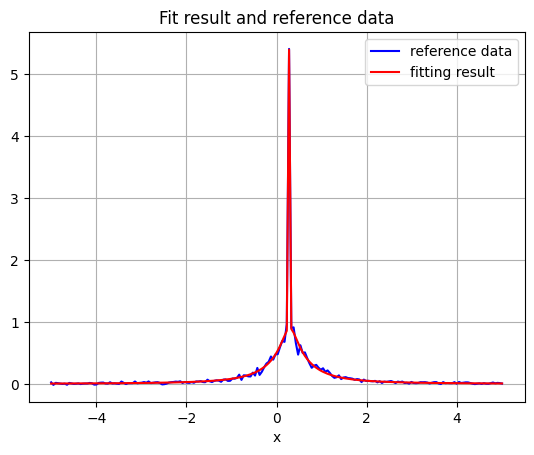

In [6]:
fig2 = plt.figure()
plt.plot(xx, equiv_sites_circle_noisy, 'b-', label='reference data')
plt.plot(xx, result.best_fit, 'r', label='fitting result')
plt.legend()
plt.xlabel('x')
plt.title('Fit result and reference data')
plt.grid();

Print values and errors of refined parameters:

In [7]:
for item in ['resTime', 'radius', 'center', 'scale']:
    print(f"{item}: {result.params[item].value} +/- {result.params[item].stderr} {dict_physical_units[item]}")

resTime: 3.0223323418811363 +/- 0.17278081176482926 ps
radius: 4.367424188198108 +/- 0.39816818761927975 Angstrom
center: 0.29066458538309625 +/- 0.004683646032517251 1/ps
scale: 1.312415165006191 +/- 0.01108276952841706 unit_of_signal/ps
